<a href="https://colab.research.google.com/github/maddogmikeb/Jira/blob/master/UltimateSprintReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies

from IPython.core.display import clear_output

!pip install -q atlassian-python-api
!pip install -q tqdm
!pip install -q matplotlib

clear_output()

In [ ]:
from IPython.core.display import clear_output

#sprint_report_url = input("Please enter the 'classic Jira sprint report' url:")

sprint_report_url = "https://brisbanecitycouncil.atlassian.net/jira/software/c/projects/FDSEWMSR/boards/401/reports/sprint-retrospective?sprint=948"
clear_output()

# Go to [Report](#Report)

In [ ]:
# Configure display

from IPython.core.display import clear_output
from google.colab import data_table
import json

data_table.enable_dataframe_formatter()

def printjson(obj):
  print(json.dumps(obj, indent=2))

clear_output()

In [ ]:
# Log in

from IPython.core.display import display, HTML, clear_output
from atlassian import Jira
from google.colab import userdata
from urllib.parse import urlparse
import re

def parse_url(url):
    pattern = r"(https?)://([^/]+)/jira/software/c/projects/([^/]+)/boards/(\d+)/reports/sprint-retrospective\?sprint=(\d+)"
    match = re.search(pattern, url)
    if match:
        protocol = match.group(1)
        base_url = match.group(2)
        project = match.group(3)
        rapidViewId = match.group(4)
        sprintId = match.group(5)
        full_base_url = f"{protocol}://{base_url}"
        return full_base_url, project, rapidViewId, sprintId
    else:
        return None, None, None, None

base_url, project, rapidViewId, sprintId = parse_url(sprint_report_url)

jira = Jira(
  url=base_url,
  username=userdata.get('atlassian_username'),
  password=userdata.get('atlassian_apikey'),
  cloud=True
)

me = jira.myself()

display(HTML('<table><tr><td>' + me["displayName"] + '</td><td><img src="' + me["avatarUrls"]["32x32"] + '"/><td></tr></table>'))


Mike Burns


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import io
from PIL import Image

def fig2img(fig):
  # Convert a Matplotlib figure to a PIL Image and return it
  buf = io.BytesIO()
  fig.savefig(buf)
  buf.seek(0)
  img = Image.open(buf)
  return img

class DataPoint:
  def __init__(self, name, count, points, color, hatch, edgeColor):
    self.name = name
    self.count = count
    self.points = points
    self.color = color
    self.hatch = hatch
    self.edgeColor = edgeColor

  def getValues(self):
    return [self.count, self.points]

def cumulateData(dataArray):
  data = np.array(dataArray)
  data_shape = np.shape(data)

  # Take negative and positive data apart and cumulate
  def get_cumulated_array(data, **kwargs):
      cum = data.clip(**kwargs)
      cum = np.cumsum(cum, axis=0)
      d = np.zeros(np.shape(data))
      d[1:] = cum[:-1]
      return d

  cumulated_data = get_cumulated_array(data, min=0)
  cumulated_data_neg = get_cumulated_array(data, max=0)

  # Re-merge negative and positive data.
  row_mask = (data<0)
  cumulated_data[row_mask] = cumulated_data_neg[row_mask]
  data_stack = cumulated_data

  return data, data_shape, data_stack

In [ ]:
status_categories = jira.get("/rest/api/2/statuscategory")

In [ ]:
import json

sprint_report = json.loads(jira.request(absolute=True, method="GET", path="{base_url}{path}?rapidViewId={rapidViewId}&sprintId={sprintId}".format(base_url = base_url, path="/rest/greenhopper/latest/rapid/charts/sprintreport", rapidViewId=rapidViewId, sprintId=sprintId)).content)

In [ ]:
import json

velocity_statistics = json.loads(jira.request(absolute=True, method="GET", path="{base_url}{path}?rapidViewId={rapidViewId}".format(base_url = base_url, path="/rest/greenhopper/1.0/rapid/charts/velocity.json", rapidViewId=rapidViewId)).content)
try:
  sprint_velocity_statistics = velocity_statistics['velocityStatEntries'][str(sprintId)]
except:
  sprint_velocity_statistics = 0
  raise Exception("Sprint has not been completed")

Exception: Sprint has not been completed

In [ ]:
import json

board_config = json.loads(jira.request(absolute=True, method="GET", path="{base_url}{path}?rapidViewId={rapidViewId}".format(base_url = base_url, path="/rest/greenhopper/1.0/rapidviewconfig/editmodel.json", rapidViewId=rapidViewId)).content)

In [ ]:
ToDoEstimate = 0
ToDoCount = 0
ProgressEstimate = 0
ProgressCount = 0

TODO_KEY_ID =  str([x['id'] for x in status_categories if x['name'] == 'To Do'][0])
INPROGRESS_KEY_ID  = str([x['id'] for x in status_categories if x['name'] == 'In Progress'][0])

for issue in sprint_report["contents"]["issuesNotCompletedInCurrentSprint"]:
  if issue["status"]["statusCategory"]['id'] == TODO_KEY_ID:
    ToDoCount += 1
    ToDoEstimate += issue['estimateStatistic']['statFieldValue']['value']

  if issue["status"]["statusCategory"]['id'] == INPROGRESS_KEY_ID:
    ProgressCount += 1
    ProgressEstimate += issue['estimateStatistic']['statFieldValue']['value'] if "value" in issue['estimateStatistic']['statFieldValue'] else 0

Removed = DataPoint(
    'Removed',
    -1 * len(sprint_report["contents"]["puntedIssues"]),
    -1 * sprint_report["contents"]['puntedIssuesEstimateSum']['value'] if "value" in sprint_report["contents"]["puntedIssuesEstimateSum"] else 0,
    '#d04437',
    None,
    '#ccc'
  )

ToDo = DataPoint(
    'ToDo',
    ToDoCount,
    ToDoEstimate,
    '#091E420F',
    None,
    '#44546F'
  )

InProgress = DataPoint(
    'InProgress',
    ProgressCount,
    ProgressEstimate,
    '#deebff',
    None,
    '#0055CC'
  )

Done = DataPoint(
    'Completed',
    len(sprint_report["contents"]["completedIssues"]),
    sprint_report["contents"]["completedIssuesEstimateSum"]['value'] if "value" in sprint_report["contents"]["completedIssuesEstimateSum"] else 0,
    '#e3fcef',
    None,
    '#216E4E'
  )

CompletedOutside = DataPoint(
    'Completed Outside',
    len(sprint_report["contents"]["issuesCompletedInAnotherSprint"]),
    sprint_report["contents"]["issuesCompletedInAnotherSprintEstimateSum"]['value'] if "value" in sprint_report["contents"]["issuesCompletedInAnotherSprintEstimateSum"] else 0,
    '#e3fcef',
    'X',
    '#216E4E'
  )

TotalCommitted = [
    len(sprint_velocity_statistics["allConsideredIssueKeys"]) if sprint_velocity_statistics else 0,
    sprint_velocity_statistics["estimated"]["value"] if sprint_velocity_statistics and 'value' in sprint_velocity_statistics["estimated"] else 0
  ]


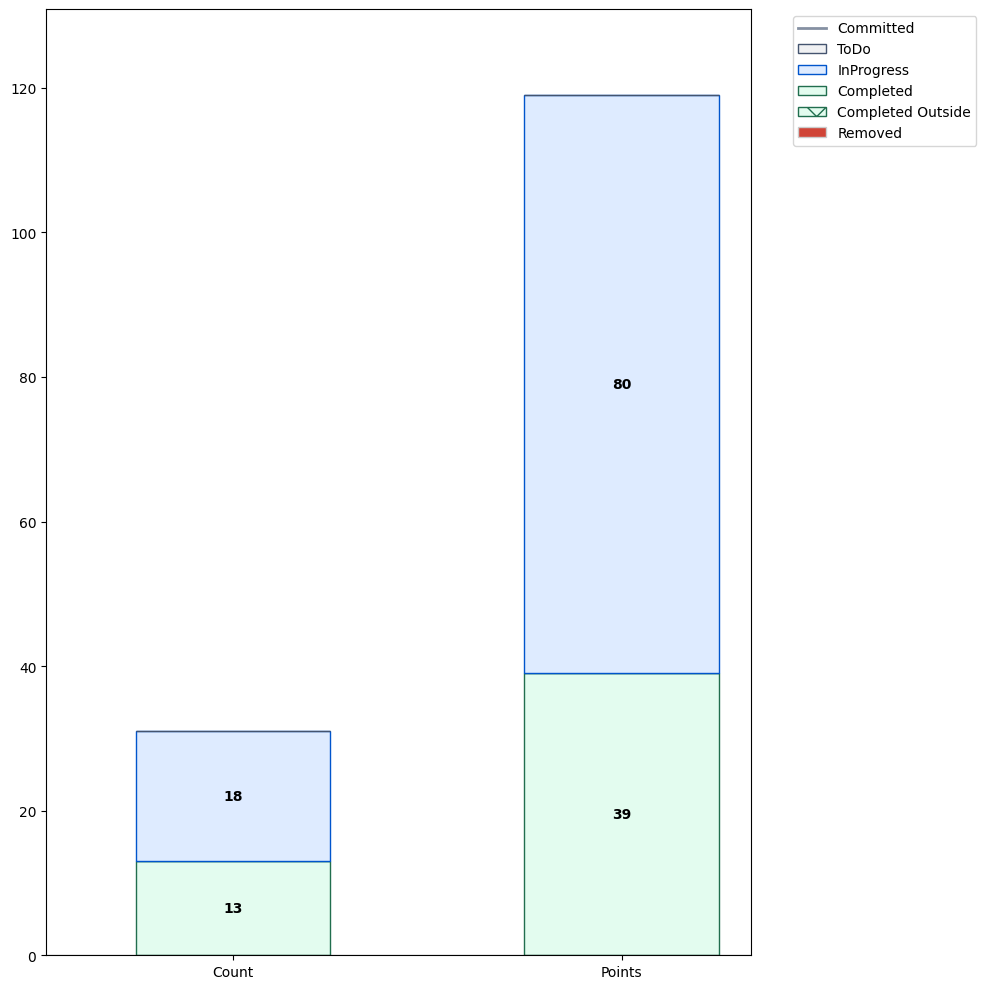

In [ ]:
from IPython.core.display import display, HTML, clear_output
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import base64

col_labels = ['Count', 'Points']

cols = [Removed.color, Done.color, CompletedOutside.color, InProgress.color, ToDo.color]
edgeColors = [Removed.edgeColor, Done.edgeColor, CompletedOutside.edgeColor, InProgress.edgeColor, ToDo.edgeColor]
hatch = [Removed.hatch, Done.hatch, CompletedOutside.hatch, InProgress.hatch, ToDo.hatch]
values = [Removed.getValues(), Done.getValues(), CompletedOutside.getValues(), InProgress.getValues(), ToDo.getValues()]

data, data_shape, data_stack = cumulateData(values)

clear_output(wait=True)

_, ax = plt.subplots(figsize=(10, 10))  # Make the chart 3x bigger

for i in np.arange(0, data_shape[0]):
  bars = ax.bar(np.arange(data_shape[1]), data[i], bottom=data_stack[i], color=cols[i], edgecolor=edgeColors[i], hatch=hatch[i], width=0.5)
  for bar in bars:
     height = bar.get_height()
     if (height > 0):
       ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{int(height)}', ha='center', va='center', color='black', fontweight='bold')

for i in range(len(TotalCommitted)):
  ax.vlines(x=i-0.4, ymin=0, ymax=(TotalCommitted[i]), color='#8590a2', linestyle='solid', linewidth=5,)
  if (TotalCommitted[i] > 0):
    ax.text(i-0.4, (TotalCommitted[i])+0.4, f'{(str(TotalCommitted[i]).rjust(3))}', color='black', horizontalalignment='center', fontweight='bold')

ax.set_xticks(np.arange(data_shape[1]))
ax.set_xticklabels(col_labels)

ax.axhline(0, color='black', linewidth=0.8)

legend_elements = [
    Line2D([0], [0], color='#8590a2', lw=2, label='Committed'),
    Patch(facecolor=ToDo.color, edgecolor=ToDo.edgeColor, label=ToDo.name),
    Patch(facecolor=InProgress.color, edgecolor=InProgress.edgeColor, label=InProgress.name),
    Patch(facecolor=Done.color, edgecolor=Done.edgeColor, label=Done.name),
    Patch(facecolor=CompletedOutside.color, edgecolor=CompletedOutside.edgeColor, hatch="X", label=CompletedOutside.name),
    Patch(facecolor=Removed.color, edgecolor=Removed.edgeColor, label=Removed.name)
  ]

ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_ylim(top=ax.get_ylim()[1] * 1.1)

plt.tight_layout()

buf = io.BytesIO()
plt.savefig(buf, format='png', pad_inches=0.5)
buf.seek(0)
image_base64 = base64.b64encode(buf.read()).decode('utf-8')

committed_vs_planned_chart = f'<img src="data:image/png;base64,{image_base64}" width="500px" height="500px  alt="Chart Image"/>'

clear_output(wait=True)

Category,Count,Points
Removed,0,0
Completed,13,39.0
Completed Outside,0,0
InProgress,18,80.0
ToDo,0,0

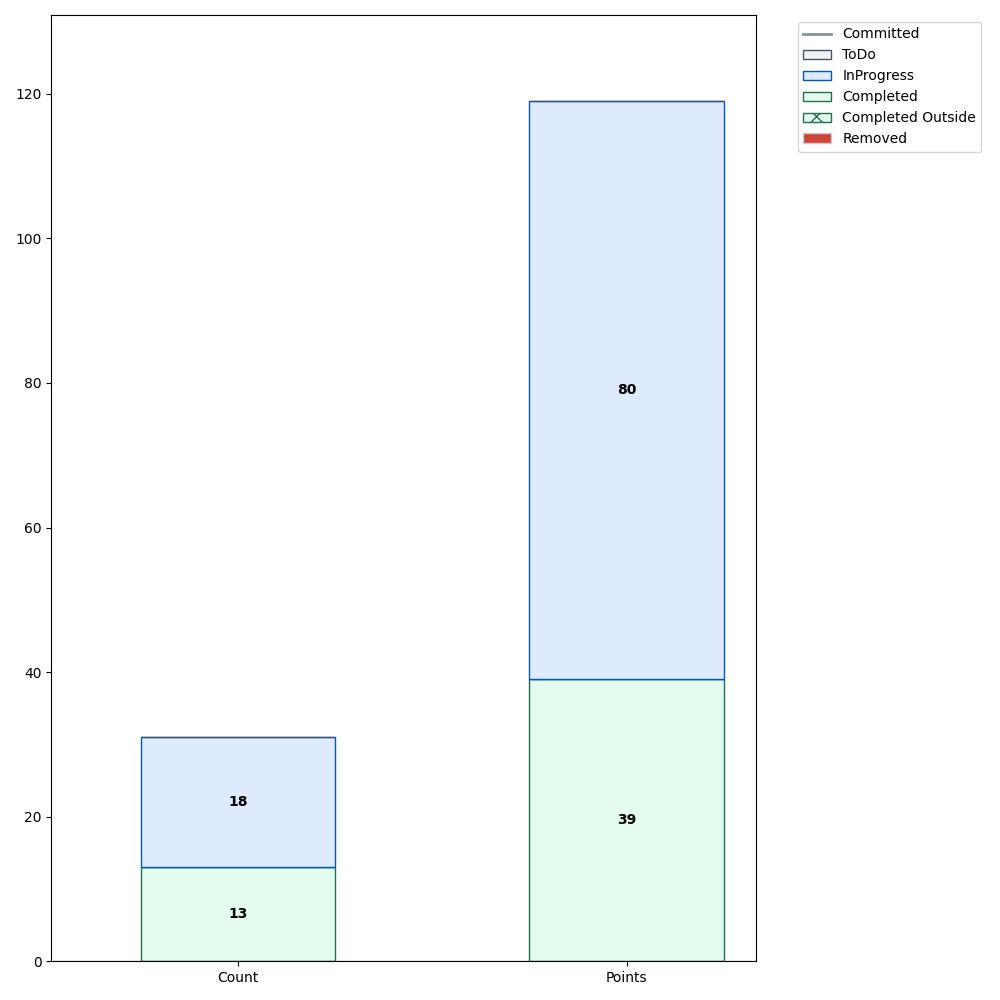

PI8 - Approvals - Sprint 1
Goal 2 | Approvals | Configuration of Short Stay Permit supporting the intended go-live. Excluding E2E Testing.
05/Mar/25 9:26 AM
18/Mar/25 12:00 AM
Sprint length: 10


In [ ]:
# prompt: given the above chart create a html table that represents the data shown

from IPython.display import HTML
import numpy as np
from datetime import datetime

# Sample data (replace with your actual data)
data = {
    'Category': ['Removed', 'Completed', 'Completed Outside', 'InProgress', 'ToDo'],
    'Count': [Removed.count, Done.count, CompletedOutside.count, InProgress.count, ToDo.count],
    'Points': [Removed.points, Done.points, CompletedOutside.points, InProgress.points, ToDo.points]
}

html_table = """
""" + committed_vs_planned_chart + """
<table>
  <thead>
    <tr>
      <th>Category</th>
      <th>Count</th>
      <th>Points</th>
    </tr>
  </thead>
  <tbody>
"""

for i in range(len(data['Category'])):
    html_table += f"""
    <tr>
      <td>{data['Category'][i]}</td>
      <td>{data['Count'][i]}</td>
      <td>{data['Points'][i]}</td>
    </tr>
    """

html_table += """
  </tbody>
</table>
"""

display(HTML(html_table))

print(sprint_report["sprint"]["name"])
print(sprint_report["sprint"]["goal"])
print(sprint_report["sprint"]["startDate"])
print(sprint_report["sprint"]["endDate"])

start = datetime.strptime(sprint_report["sprint"]["isoStartDate"], "%Y-%m-%dT%H:%M:%S%z").date()
end = datetime.strptime(sprint_report["sprint"]["isoEndDate"], "%Y-%m-%dT%H:%M:%S%z").date()

weekmask = ' '.join([k.capitalize()[:3] for k,v in dict(board_config['workingDaysConfig']['weekDays']).items() if v == True])

holidays = [datetime.strptime(date, "%Y-%m-%d").date() for date in [x['iso8601Date'] for x in board_config['workingDaysConfig']['nonWorkingDays']]]

days = np.busday_count(start, end, holidays=holidays, weekmask=weekmask)
if (days > 1):
  days = days + 1
print('Sprint length:', days)


#Report
<a id="Report" />